# <u>Take Home Assignment</u>

### Part 1 - Exploratory    data    analysis

In [1]:
#import libaries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
#list the files in the directory
os.listdir()

['.ipynb_checkpoints',
 'logins.json',
 'ultimate_challenge.ipynb',
 'ultimate_data_challenge.json',
 'ultimate_data_science_challenge.pdf']

In [3]:
#read the logins.json file to pandas and inspect
logins = pd.read_json('logins.json')
#Add a 1 to each instance to perform a count later on
logins['counter'] = 1
logins.head()

,login_time,counter
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [4]:
#Summary data on the login data
logins['login_time'].describe()

count                   93142
unique                  92265
top       1970-02-12 11:16:53
freq                        3
first     1970-01-01 20:12:16
last      1970-04-13 18:57:38
Name: login_time, dtype: object

In [5]:
#Adding a time column for future use
logins['time'] = [datetime.time(d) for d in logins['login_time']] 

In [6]:
#converting the login time to an index to perform resampling
logins.index = logins['login_time']

In [7]:
#resampling the dataframe to a series
_15min = logins.resample('15T')['counter'].count()

C:\Users\abels\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


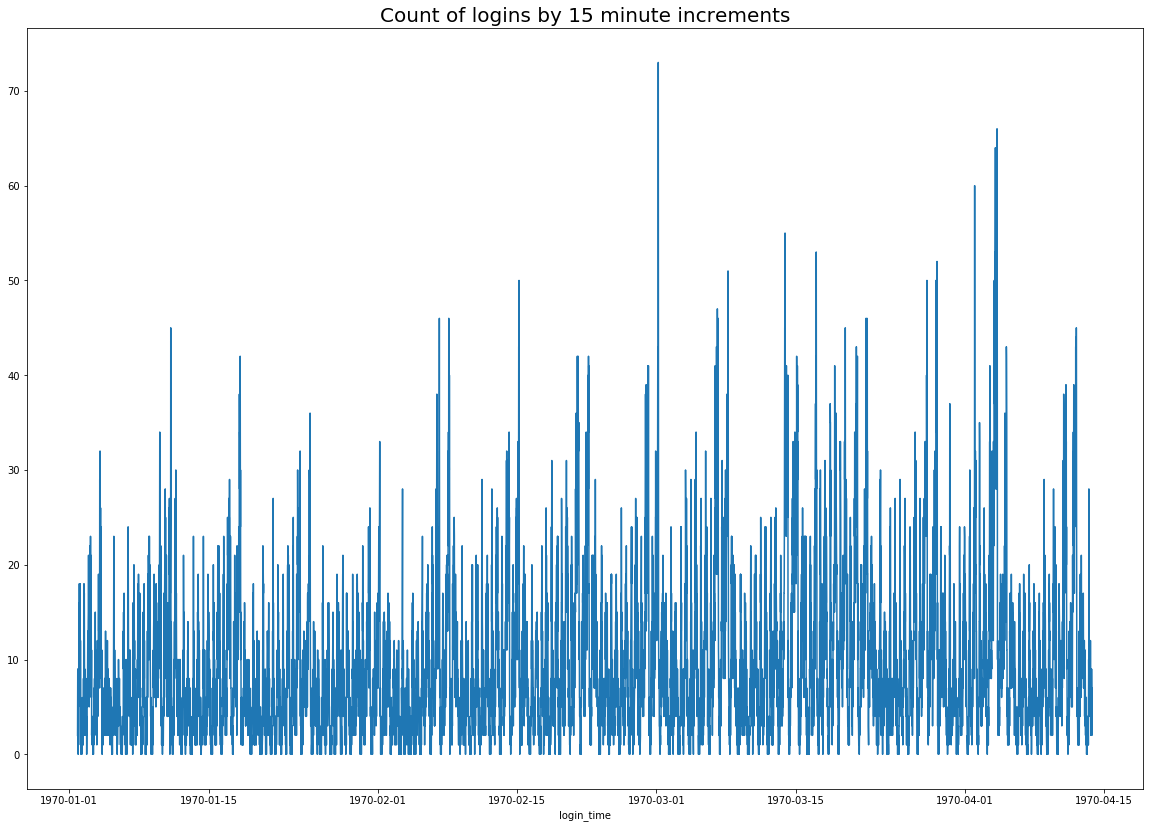

In [8]:
#Plot the 15min resample
plt.figure(figsize=(20,14))
plt.title('Count of logins by 15 minute increments', size=20)
plot_ = sns.lineplot(x=_15min.index, y=_15min.values)

#### There appears to be a huge outlier around March 1st. This could either be a spike in traffic or an error in the data.

In [9]:
#converting to pandas dataframe
_15min = _15min.reset_index()

In [10]:
#adding additional features for grouping
_15min['date'] = _15min['login_time'].dt.date
_15min['time'] = _15min['login_time'].dt.time
_15min['dow'] = _15min['login_time'].dt.dayofweek

In [11]:
_15min.head()

,login_time,counter,date,time,dow
0,1970-01-01 20:00:00,2,1970-01-01,20:00:00,3
1,1970-01-01 20:15:00,6,1970-01-01,20:15:00,3
2,1970-01-01 20:30:00,9,1970-01-01,20:30:00,3
3,1970-01-01 20:45:00,7,1970-01-01,20:45:00,3
4,1970-01-01 21:00:00,1,1970-01-01,21:00:00,3


In [12]:
# grouping by date
re_date = _15min.groupby('date')['counter'].sum()
re_date = re_date.reset_index()
re_date.head()

,date,counter
0,1970-01-01,112
1,1970-01-02,681
2,1970-01-03,793
3,1970-01-04,788
4,1970-01-05,459


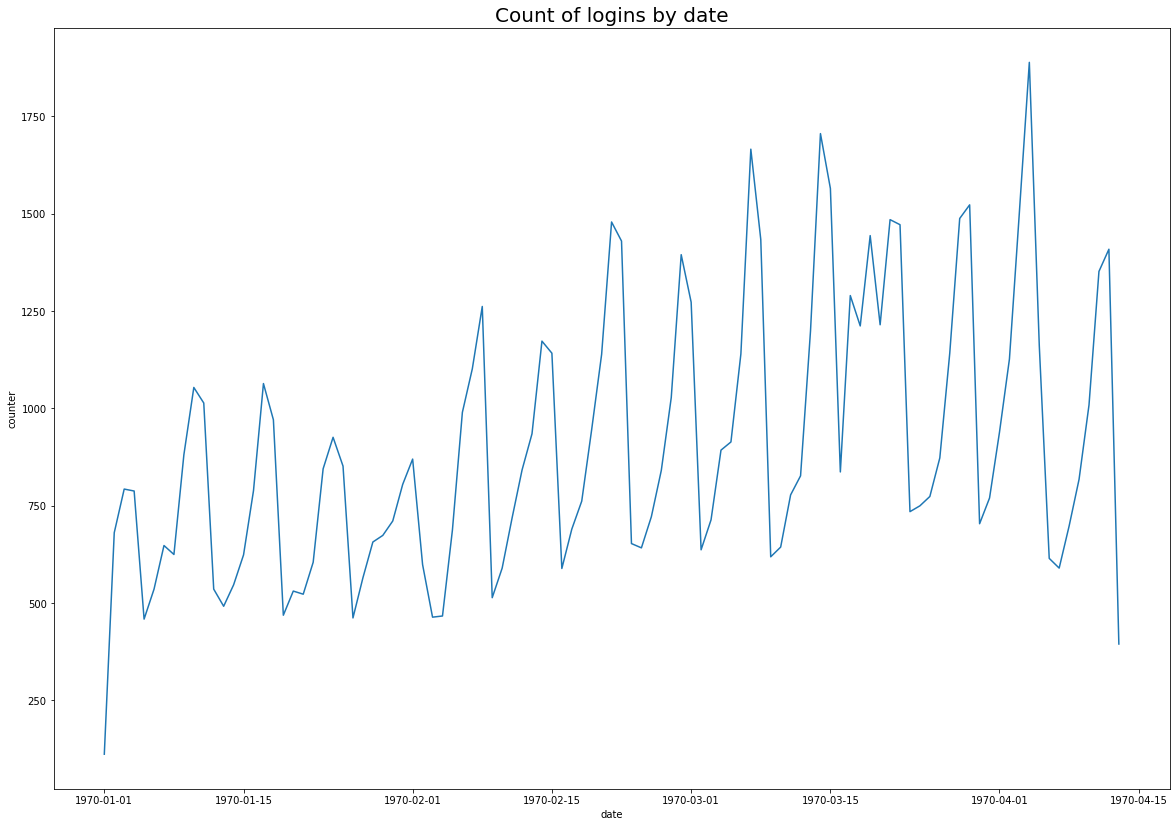

In [13]:
#Plot the date group
plt.figure(figsize=(20,14))
plt.title('Count of logins by date', size=20)
plot_ = sns.lineplot(x=re_date.date, y=re_date.counter)

#### We see that there is an increase followed by a recent dip in logins. Purhaps there is a higher churn in userbase in recent use.

#### Further statistical analysis is required to determine the significance of the dip.

In [14]:
# Grouping by 15 minute increments
re_time = _15min.groupby('time')['counter'].sum()
re_time = re_time.reset_index()
re_time.head()

,time,counter
0,00:00:00,1439
1,00:15:00,1547
2,00:30:00,1525
3,00:45:00,1482
4,01:00:00,1549


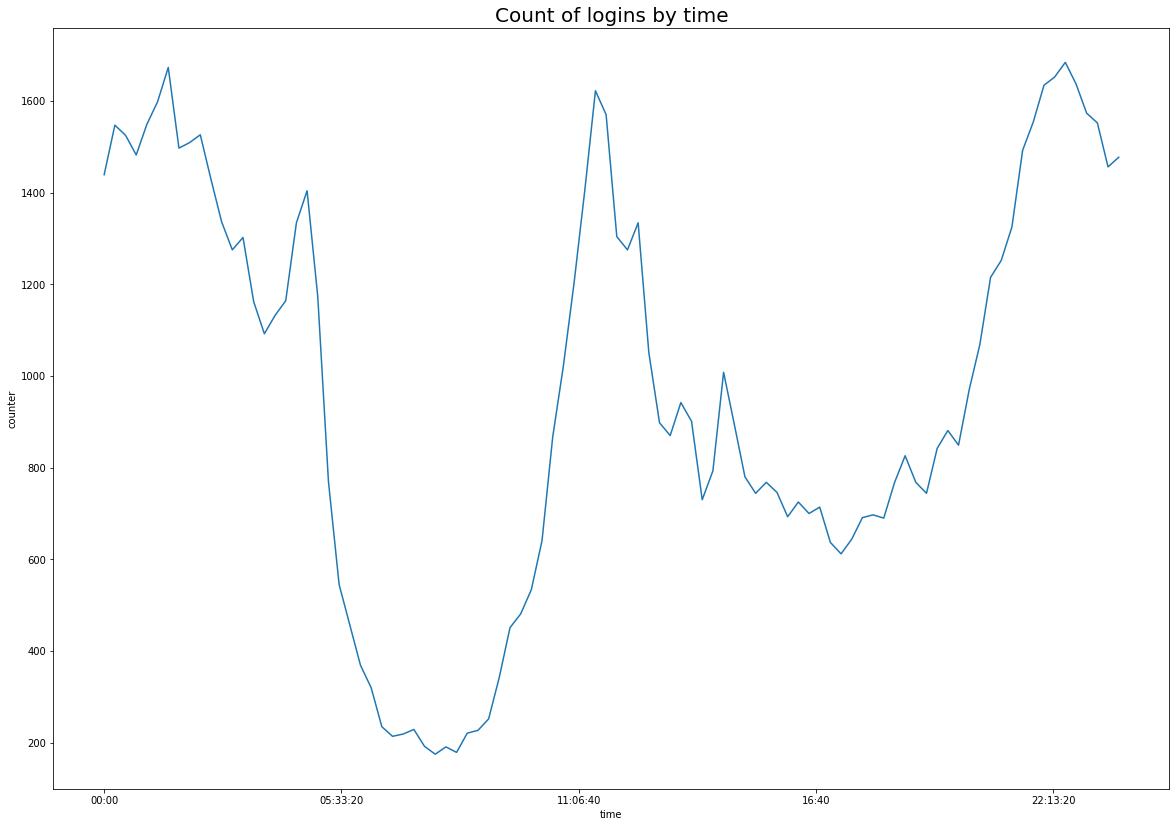

In [15]:
#Plot the date group
plt.figure(figsize=(20,14))
plt.title('Count of logins by time', size=20)
plot_ = sns.lineplot(x=re_time.time, y=re_time.counter)

In [16]:
# Grouping by day of week
re_dow = _15min.groupby('dow')['counter'].mean()
re_dow = re_dow.reset_index()
re_dow.head()

,dow,counter
0,0,6.213380
1,1,6.895833
2,2,7.692708
3,3,8.794118
4,4,10.561111


In [17]:
#adding weekday names for dow graph
weekday_names = "Mon Tue Wed Thu Fri Sat Sun".split(' ')

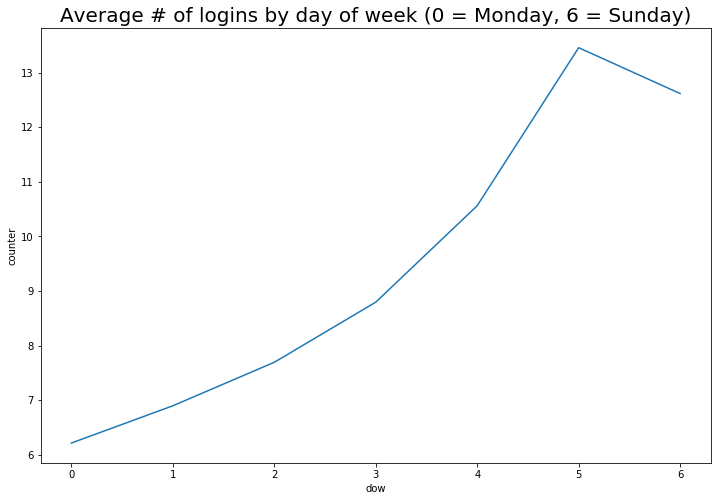

In [18]:
#Plot the date group
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Average # of logins by day of week (0 = Monday, 6 = Sunday)', size=20)
plot_ = sns.lineplot(x=re_dow.dow, y=re_dow.counter)

#### We see that the average number of logins increases as the week progresses. We can suspect that the service correlates to leisure time.

### Part 2 ‑ Experiment and metrics design  

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
    * a. how you will implement the experiment 
    * b. what statistical test(s) you will conduct to verify the significance of the observation 
    * c. how you would interpret the results and provide recommendations to the city operations team along with any caveats


___

<b>1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? </b>

The main goal of the program is to "encouraging driver partners to serve both cities". 

As such, the metric must help quantify the overall success of the program (ie. are there more drivers between the cities).

<i><b><u>The key metric I would choose is the average tolls per license plate per day.</u></b></i> Assuming that license plate could be used to determine group (ie partner driver & non-partner driver), we could look at the effect of the program on each group after implementation.

___

<b>2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:</b>

<b>a. how you will implement the experiment </b>

To start, we would need to be able to distinguish "partner" drivers. Asumming that the toll reimbursement would be done through a license plate registration, this would provide us with the ability to track how behavior changes with the program.


Furthermore, we would need data before the program has launched so we could make a comparison with after the program has launched. If there is no historical data, we would have to start tracking license plate data with the intention of implementing the program at a future date.

<b>b. what statistical test(s) you will conduct to verify the significance of the observation </b>

The main goal is to evaluate the difference in tolls after the program has been implemented. For this reason, an A/B test (of sorts) could be used to make the comparison between the two.


The mean number of daily tolls on a partner driver basis could be compared after the program has been implemented. In this instance, we would use a t-test to determine if the means are significatly different. A t-test would be used because we do not know the true population mean and standard deviation.

<b>c. how you would interpret the results and provide recommendations to the city operations team along with any caveats</b>

Using the null hypothesis of Ho: u0 - u1 = 0 (Ha: u0 - u1 != 0), we would perform a t-test to evaluate means. If we receive a p-value that is > 0.05, we would reject the null hypothesis and conclude that the program did in fact have some impact in toll participation.


The caveats for this program are mainly around timing. There are many externalities that could impact toll participation. For example, a holiday or even a severe winter storm might skew results. It's important that we choose a time period with consistent weather as well as a time period with few or no stat holidays/events.


A good potential month to run the experiment might be during a summer month.

### Part 3 ‑ Predictive modeling

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 


2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 


3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­ term rider retention (again, a few sentences will suffice). 


Data description 
* city:   city  this user  signed  up  in 
* phone:  primary device  for  this user 
* signup_date:  date  of  account  registration;  in  the  form  ‘YYYY MM DD’ 
* last_trip_date:   the  last  time  this user  completed a  trip;  in  the  form  ‘YYYY MM DD’ 
* avg_dist:   the average  distance  in miles per  trip  taken  in  the  first 30 days after  signup * avg_rating_by_driver:   the  rider’s average  rating over all of  their  trips 
* avg_rating_of_driver:   the  rider’s average  rating of  their drivers over all of  their  trips 
* surge_pct:   the percent  of  trips  taken with  surge multiplier > 1 
* avg_surge:   The average  surge multiplier over all of  this user’s  trips 
* trips_in_first_30_days:   the  number of  trips  this user  took  in  the  first 30 days after signing up 
* ultimate_black_user:   TRUE  if  the user  took an Ultimate Black  in  their  first 30 days; FALSE otherwise 
* weekday_pct:   the  percent  of  the user’s  trips occurring during a weekday 


<b><u>Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</b></u>

In [19]:
#list the directory
os.listdir()

['.ipynb_checkpoints',
 'logins.json',
 'ultimate_challenge.ipynb',
 'ultimate_data_challenge.json',
 'ultimate_data_science_challenge.pdf']

In [20]:
#read the json into a file; convert to pandas dataframe
with open('ultimate_data_challenge.json') as f:
   df = json.load(f)
df = pd.DataFrame(df)

In [21]:
df.head() #inspect the data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [22]:
df.describe() #inspect the data

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


##### Adding/formatting features

In [23]:
from datetime import datetime
from datetime import timedelta

In [24]:
type(df['last_trip_date'][0])

str

In [25]:
#format from date string to timestamp
df['last_trip_date'] = df['last_trip_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['signup_date'] = df['signup_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
type(df['last_trip_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [26]:
df['last_trip_date'].max() # latest date in the system

Timestamp('2014-07-01 00:00:00')

In [27]:
# adding the feature 'retained'. If the date is less than 30 days ago then 'retained' == 1, else 0
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if df['last_trip_date'].max() - timedelta(days=30) <= x else 0)

In [28]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


## EDA

In [29]:
# determine retained customer count
df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [30]:
print ('Average Retention Rate: {:f}%'.format((df['retained'].value_counts()[1] / df['retained'].value_counts().sum()) * 100))
print ('Sample Size: {}'.format(df['retained'].value_counts().sum()))

Average Retention Rate: 37.608000%
Sample Size: 50000


#### EDA by city

In [31]:
# adding a couple of group objects for future use
city_grp = df.groupby('city')['city'].count()
city_grp_r = df.groupby('city')['retained'].sum()

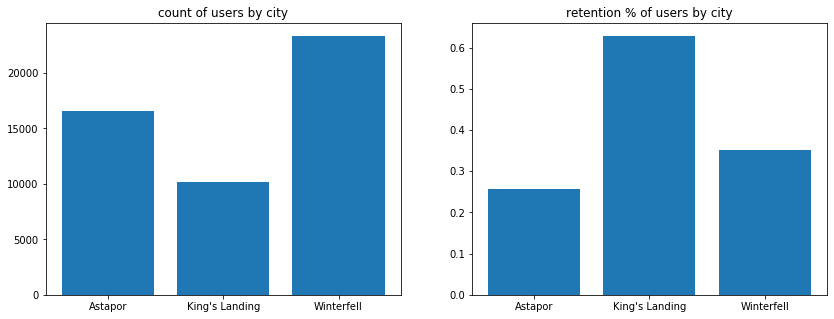

In [32]:
# adding plots - total count and retention rate by city
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.set_title('count of users by city')
ax1.bar(city_grp.index, city_grp.values)
ax2.set_title('retention % of users by city')
ax2.bar(city_grp_r.index, city_grp_r.values / city_grp.values)
plt.show()

##### We see that King's Landing is performing very well in terms of retaining customers. Astapor is not performing compared to it's peer group. This could be for a number of demographic reasons. One idea is looking into marketing of offers to improve the retention rate for Astapor.

___

#### EDA by phone

In [33]:
phone_grp = df.groupby('phone')['retained'].mean()

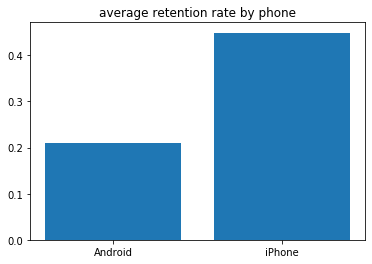

In [34]:
# adding average retained rate by phone type
plt.bar(phone_grp.index, phone_grp.values)
plt.title('average retention rate by phone')
plt.show()

#### We see that iPhone users have a higher retention rate. One hypothesis is that the app on the apple store is a better user experience. Or purhaps iPhone users are more likely to spend money on convenience services. Further investigation is required to determine the difference in retention rate.

___

<b><u>Correlation between the variables</u></b>

In [35]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [36]:
# creating new df that only has numberic values for correlation matrix
df_corr = df[['trips_in_first_30_days','avg_rating_of_driver', 'avg_surge', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained']]
df_corr.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0


In [37]:
# creating the matrix
df_corr = df_corr.corr()

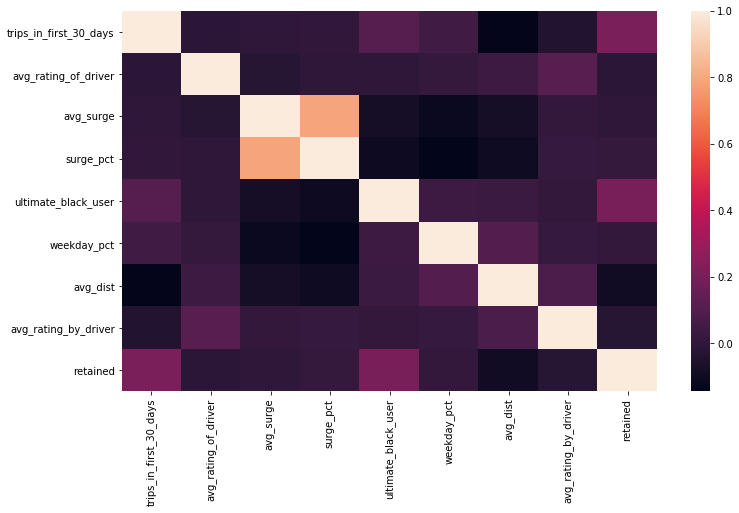

In [38]:
# display the correlation matrix as a seaborn heatmap
plt.figure(figsize=(12,7))
sns.heatmap(df_corr)
plt.show()

#### We see that avg_surge and surge_pct are positively correlated. When building out the model, one of the variables could be potentially omitted to correlation between the dependant variables.

### Pedictive Modeling

In [39]:
# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [40]:
# inspecting the dataframe
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [41]:
# inspecting data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
retained                  50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


##### We see that there are a number of missing values in the data. 

##### All data with a null value will be dropped. The model will then be trained on a number of different sample sizes to determine if the samples with null values are important to the overall performance of the model.

In [42]:
# dropping null values
df_t = df.dropna()

In [43]:
# setting up dummy variables for string features
dummy_var = pd.get_dummies(df_t[['city','phone']])
dummy_var.drop(columns=['city_Winterfell', 'phone_iPhone'], axis=1, inplace=True)

In [44]:
# adding target variable and dropping unnessesary features
y = df_t['retained']
X = df_t.drop(columns=['city', 'signup_date', 'last_trip_date', 'phone', 'retained'], axis=1)

In [45]:
# merging the new dummy features onto a main dataframe
X = pd.concat( [X, dummy_var], axis=1)

In [46]:
X.head() #inspecting

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,phone_Android
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1,0,1
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,0,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0,1,0
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,1


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) # spliting the data for training

In [48]:
X_train.head() #inspecting

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,phone_Android
39593,1,5.0,1.0,0.0,False,100.0,0.95,5.0,0,0,0
48904,1,4.5,1.0,0.0,False,50.0,2.71,5.0,0,1,0
31374,1,5.0,1.0,0.0,True,100.0,5.33,5.0,1,0,0
40490,0,5.0,1.0,0.0,True,87.5,3.54,4.9,0,0,1
15082,2,3.7,1.0,0.0,True,90.0,3.91,5.0,0,0,0


In [49]:
y_train.head() # inspecting target variable

39593    0
48904    0
31374    0
40490    1
15082    1
Name: retained, dtype: int64

### Model Training

Logistic Regression was chosen as the first model. The model was chosen for the following reasons:
* The output is binary, which lends itself well to logistic
* It's easy to determine which variables explain the overall performance of the model.
* It scales well on larger sample sizes. The model could be scaled to include other cities
* The data is relatively balanced in terms of retained / non-retrained customers
* For this level of feature complexity, a linear model is likely sufficient.

In [50]:
columns = X_train.columns

In [51]:
# Creating and fitting the model
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

C:\Users\abels\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
# Print out the overall score as well as the confusion matrix
score = logreg.score(X_test, y_test)
print('Logistic Regression Score: {}'.format(score))
confusion_matrix(y_test, logreg.predict(X_test))

Logistic Regression Score: 0.703341778260345


array([[4023,  883],
       [1576, 1807]], dtype=int64)

#### The model doesn't do as good of a job of predicting who is a retained user vs who is likely to not be a retained user

In [53]:
feat_i = pd.DataFrame(data = {'variable': X.columns, 'coef': logreg.coef_[0]})
feat_i['importance'] = abs(feat_i['coef'])
feat_i.sort_values(by='importance', ascending=False)

,variable,coef,importance
9,city_King's Landing,1.178816,1.178816
10,phone_Android,-1.122629,1.122629
4,ultimate_black_user,0.908890,0.908890
8,city_Astapor,-0.546524,0.546524
7,avg_rating_by_driver,-0.222423,0.222423
2,avg_surge,-0.213421,0.213421
0,trips_in_first_30_days,0.099973,0.099973
1,avg_rating_of_driver,-0.053690,0.053690
6,avg_dist,-0.038547,0.038547
3,surge_pct,0.004283,0.004283


#### We see that the city, type of phone and if you used the premium service in the first 30 days are the most important features in determining customer churn

___

<b><u> Determining if the sample size is negatively affecting by dropping all null/none values </u></b>

In [54]:
# reseting model
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

In [55]:
len(X_train) / 1000

33.156

In [56]:
# Fitting logreg on different sample sizes to determine if sample size is an issue. 
# If it is, then we could potentially bolster the sample size by including the null values that were dropped earlier.
scores = []
for a in range(1,34):
    logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
    logreg.fit(X_train[0:1000 * a], y_train[0:1000 * a])
    scores.append(logreg.score(X_test, y_test))

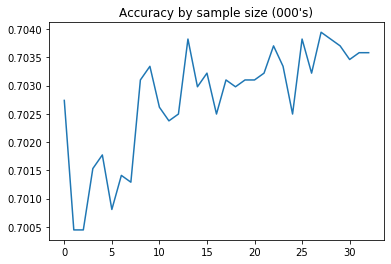

In [57]:
# plotting the scores by sample size
plt.title('Accuracy by sample size (000\'s)')
plt.plot(scores)
plt.show()

#### We see that the model converges very quickly. As such, we can see that sample size has a small impact on overall performance. As such, we can simply exclude all samples with null values.

___

### Improving model performance

#### We can improve the model performance through : scaling data, adding grid search, implementing cross validation

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

In [61]:
to_scale = X[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]

In [62]:
scaler = StandardScaler()
scaled = scaler.fit_transform(to_scale)

In [63]:
scaled = pd.DataFrame(scaled, columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])

In [74]:
X = pd.concat(([scaled.reset_index(), X[['ultimate_black_user', 'city_Astapor', 'city_King\'s Landing', 'phone_Android']].reset_index()]), axis=1)

In [76]:
X.drop(columns=['index'], inplace=True)

In [77]:
# Splitting the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [78]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 1, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [79]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)

In [80]:
# Fit grid search
best_model = clf.fit(X_train, y_train)

C:\Users\abels\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abels\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abels\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abels\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abels\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [81]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 10.0


In [82]:
best_model.score(X_test, y_test)

0.7076848835806491

#### We see from feature importance that the values with a high negative coefficient are variables that signify a higher likelihood of not being a return customer.


#### Knowing this, we can try to impact the business by for example, improving the android app, offering Astapor customers a free ride in upgraded black service or even offering users who use the app during serge times, a better discount.

#### Model tuning does not improve the model significantly. This might elude to the model not being complex enough to fit the data properly. As such, a random forest model will be trained.

In [83]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rfscore = rf.score(X_test, y_test)
print (rfscore)

C:\Users\abels\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7333815900591145


#### A significant improvement on the model performance between logreg and rf concludes the data is better suited for a non-linear model.

### Hyperparameter tuning - Random Forest

In [84]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 40, 100]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [85]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.6min finished


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [86]:
# print out the best model
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
# print out the best score
grid_search.best_score_

0.7770539268910605

In [88]:
# create dataframe to house feature importance
feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                   index = columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [89]:
feature_importances

,importance
avg_dist,0.151985
weekday_pct,0.134906
ultimate_black_user,0.133129
surge_pct,0.130593
city_King's Landing,0.094759
avg_surge,0.088040
trips_in_first_30_days,0.066088
phone_Android,0.061134
avg_rating_of_driver,0.058142
avg_rating_by_driver,0.053258


In [90]:
# predict on holdout
pred = grid_search.best_estimator_.predict(X_test)

In [91]:
# print accuracy score
accuracy_score(y_test,pred)

0.7736759560863795

In [93]:
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,city_Astapor,city_King's Landing,phone_Android
13684,0.096156,0.646456,-0.371440,-0.485689,1.112936,-0.789108,0.552529,False,0,0,0
26111,2.066946,-1.463601,-0.371440,-0.485689,0.193750,-0.410107,0.058216,False,0,0,0
27891,-0.642890,-4.222907,1.288981,3.154775,1.112936,1.438249,-0.188941,True,0,1,0
26936,-0.642890,0.646456,-0.371440,-0.485689,-0.323292,-0.258507,0.552529,False,1,0,1
2888,0.835202,0.646456,-0.371440,-0.485689,0.087469,-0.147722,0.058216,False,0,0,0


### Once scaled, the model shows that avg_dist, weekday_pct, ultimate_black_user and surge_pct are the most important features.

### To improve retention rate, the company could offer free premium black service for the first month, market during surge hours or even offer discounts for heavy weekday users.